# Energy Forecasting Practice

I'll be working off the __[PJM Hourly Energy Consumption Data set](https://www.kaggle.com/robikscube/hourly-energy-consumption)__ found on Kaggle

In [284]:
#Import necessary libraries

import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O
import matplotlib.pyplot as plt #MATLAB-style plotting
import seaborn as sns #creates pretty plots
%matplotlib inline }{}}
import warnings
import matplotlib.dates as mdates
import datetime as dt

import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

In [187]:
#Import the data

df_energy = pd.read_csv('DAYTON_hourly.csv')
df_weather = pd.read_csv('NOAA Dayton Climate Data.csv')

### Exploring the Energy Data First

In [188]:
#Check the first 2 rows of the data set

df_energy.head(2)

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0


In [189]:
#Check the data types of the columns

df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Datetime   121275 non-null  object 
 1   DAYTON_MW  121275 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [190]:
#Check if there are any null or missing values 

df_energy.isnull().sum()

Datetime     0
DAYTON_MW    0
dtype: int64

There are no null values

In [191]:
#Convert the object column to a datetime column 

df_energy['Datetime'] = pd.to_datetime(df_energy.Datetime)
df_energy.set_index('Datetime')

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596.0
2004-12-31 02:00:00,1517.0
2004-12-31 03:00:00,1486.0
2004-12-31 04:00:00,1469.0
2004-12-31 05:00:00,1472.0
...,...
2018-01-01 20:00:00,2732.0
2018-01-01 21:00:00,2724.0
2018-01-01 22:00:00,2664.0


In [192]:
#Create new features to work with 

df_energy['hour'] = df_energy['Datetime'].dt.hour
df_energy['dayofweek'] = df_energy['Datetime'].dt.dayofweek
df_energy['quarter'] = df_energy['Datetime'].dt.quarter
df_energy['month'] = df_energy['Datetime'].dt.month
df_energy['year'] = df_energy['Datetime'].dt.year
df_energy['dayofyear'] = df_energy['Datetime'].dt.dayofyear
df_energy['dayofmonth'] = df_energy['Datetime'].dt.day
df_energy['weekofyear'] = df_energy['Datetime'].dt.weekofyear

In [193]:
#Assign recognizable names to the dayofweek feature

dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df_energy['Day of Week']=df_energy['dayofweek'].map(dmap)

In [194]:
#Assign recognizable names to the month feature

dmap = {12:'Dec',1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov'}
df_energy['Month']=df_energy['month'].map(dmap)

In [195]:
df_energy.head(2) #making sure the mapping was correct

,Datetime,DAYTON_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Day of Week,Month
0,2004-12-31 01:00:00,1596.0,1,4,4,12,2004,366,31,53,Fri,Dec
1,2004-12-31 02:00:00,1517.0,2,4,4,12,2004,366,31,53,Fri,Dec


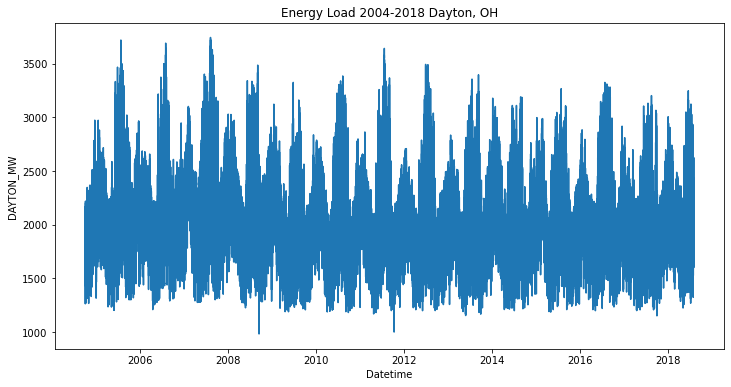

In [196]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_energy, x="Datetime", y="DAYTON_MW", palette='viridis')
plt.title("Energy Load 2004-2018 Dayton, OH")
plt.show()

In [197]:
#Create a heatmap to visualize data during the day

dayHour = df_energy.groupby(by=['Day of Week','hour']).mean()['DAYTON_MW'].unstack()

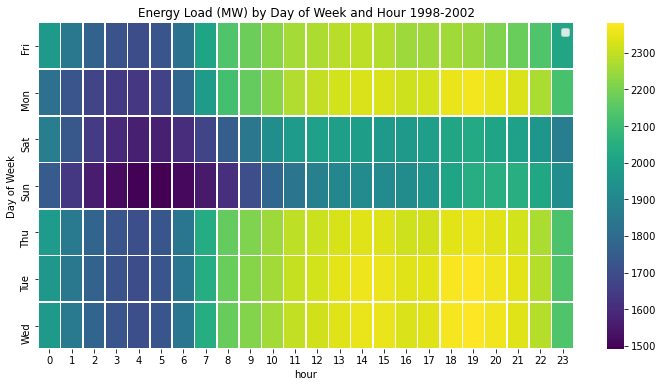

In [198]:
plt.figure(figsize=(12,6))
sns.heatmap(dayHour,cmap='viridis', linewidths=0.5)
plt.title("Energy Load (MW) by Day of Week and Hour 1998-2002")
plt.legend("Test")

Interesting that there is less energy used on Sunday and Saturday. Also, it's clearly shown the peak usage hours are in the evenings at 6pm-ish, when everyone is coming home from work and turning on their TVs and dishwashers and heaters/ACs. Proof that load shifting can be done to reduce the peak load on utilities and take opportunity of cheaper energy or more readily available off-hours. 

Text(0.5, 1.0, 'Energy Load by Month for Each Hour')

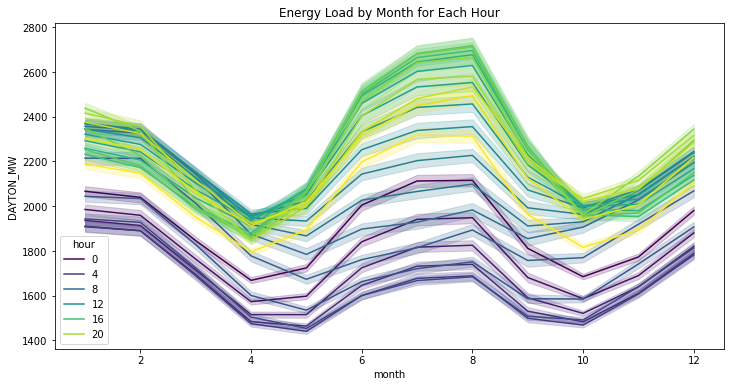

In [199]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_energy, x="month", y="DAYTON_MW", hue="hour", palette='viridis')
plt.title("Energy Load by Month for Each Hour")

In [200]:
#Create a heatmap to visualize data during the year

monthHour = df_energy.groupby(by=['month','hour']).mean()['DAYTON_MW'].unstack()

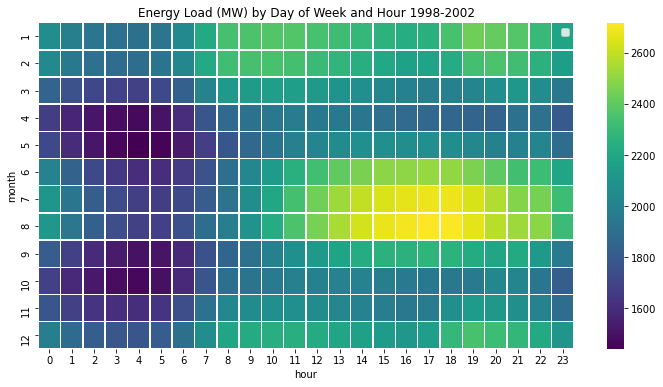

In [201]:
plt.figure(figsize=(12,6))
sns.heatmap(monthHour,cmap='viridis', linewidths=0.5)
plt.title("Energy Load (MW) by Day of Week and Hour 1998-2002")
plt.legend("Test")

My hypothesis is that the least energy is used on a Sunday in October

My hypothesis is that the most energy is used on a Thursday in August

Let's check these guesses!

In [202]:
df_energy[df_energy['DAYTON_MW']==df_energy['DAYTON_MW'].max()]

,Datetime,DAYTON_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Day of Week,Month
23216,2007-08-08 15:00:00,3746.0,15,2,3,8,2007,220,8,32,Wed,Aug


Correct! 

In [203]:
df_energy[df_energy['DAYTON_MW']==df_energy['DAYTON_MW'].min()]

,Datetime,DAYTON_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Day of Week,Month
31089,2008-09-14 18:00:00,982.0,18,6,3,9,2008,258,14,37,Sun,Sep


Close! 

Text(0.5, 1.0, 'Average Energy Consumption Per 2005-2018')

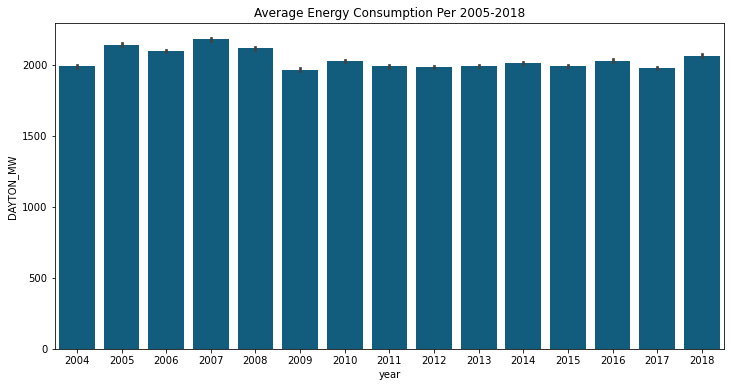

In [204]:
plt.figure(figsize=(12,6))
sns.barplot(x='year',y="DAYTON_MW", data=df_energy, color='#00638f')
plt.title("Average Energy Consumption Per 2005-2018")

It makes sense that energy consumption increases as the years go on (global warming and also more appliances/modernization)

### Exploring the Weather Data

In [205]:
#Check the data types of the columns

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40899 entries, 0 to 40898
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       40899 non-null  object 
 1   TAVG (Degrees Fahrenheit)  0 non-null      float64
 2   TMAX (Degrees Fahrenheit)  40233 non-null  float64
 3   TMIN (Degrees Fahrenheit)  40022 non-null  float64
 4   PRCP (Inches)              40459 non-null  float64
 5   SNOW (Inches)              32655 non-null  float64
 6   SNWD (Inches)              28680 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.2+ MB


In [206]:
df_weather['Date'] = pd.to_datetime(df_weather.Date, yearfirst = True)

In [207]:
df_weather.set_index('Date')

,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
Date,,,,,,
1893-12-01,NaN,40.0,15.0,NaN,0.0,NaN
1893-12-02,NaN,30.0,14.0,NaN,0.0,NaN
1893-12-03,NaN,34.0,23.0,1.33,1.0,NaN
1893-12-04,NaN,27.0,18.0,NaN,0.0,NaN
1893-12-05,NaN,34.0,20.0,NaN,0.0,NaN
...,...,...,...,...,...,...
2016-04-26,NaN,84.0,56.0,0.00,0.0,NaN
2016-04-27,NaN,88.0,46.0,0.32,0.0,NaN
2016-04-28,NaN,63.0,45.0,0.19,0.0,NaN


In [208]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40899 entries, 0 to 40898
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       40899 non-null  datetime64[ns]
 1   TAVG (Degrees Fahrenheit)  0 non-null      float64       
 2   TMAX (Degrees Fahrenheit)  40233 non-null  float64       
 3   TMIN (Degrees Fahrenheit)  40022 non-null  float64       
 4   PRCP (Inches)              40459 non-null  float64       
 5   SNOW (Inches)              32655 non-null  float64       
 6   SNWD (Inches)              28680 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 2.2 MB


In [209]:
#Since the energy data only starts at 12-31-2004, I don't need any of the other previous historical data

df_weather = df_weather[df_weather['Date']>'2004-09-01']

In [210]:
#Check if there are any null or missing values 

df_weather.isnull().sum()

Date                            0
TAVG (Degrees Fahrenheit)    4136
TMAX (Degrees Fahrenheit)     133
TMIN (Degrees Fahrenheit)     158
PRCP (Inches)                  29
SNOW (Inches)                1713
SNWD (Inches)                1780
dtype: int64

In [211]:
#Filling in null values with averages in TMAX and TMIN for now, though in the future I might want to use rolling
#averages instead

df_weather['TMAX (Degrees Fahrenheit)'].fillna(axis='rows', value = df_weather['TMAX (Degrees Fahrenheit)'].mean(), inplace = True)
df_weather['TMIN (Degrees Fahrenheit)'].fillna(axis='rows', value = df_weather['TMIN (Degrees Fahrenheit)'].mean(), inplace = True)

In [212]:
#Creating a function to fill in the TAVG column with the mean of TMAX and TMIN for each row

df_weather['TAVG (Degrees Fahrenheit)']=df_weather[['TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)']].mean(axis=1)

In [213]:
#Checking to see if null PRCP values are meant to be 0 or not

df_weather[df_weather['PRCP (Inches)'] <1]

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
36763,2004-09-02,72.000000,83.0,61.000000,0.00,0.0,0.0
36764,2004-09-03,64.547637,85.0,44.095274,0.14,0.0,0.0
36765,2004-09-04,74.000000,81.0,67.000000,0.03,0.0,0.0
36766,2004-09-05,76.500000,87.0,66.000000,0.00,0.0,0.0
36767,2004-09-06,77.000000,88.0,66.000000,0.00,0.0,0.0
...,...,...,...,...,...,...,...
40894,2016-04-26,70.000000,84.0,56.000000,0.00,0.0,NaN
40895,2016-04-27,67.000000,88.0,46.000000,0.32,0.0,NaN
40896,2016-04-28,54.000000,63.0,45.000000,0.19,0.0,NaN
40897,2016-04-29,61.000000,70.0,52.000000,0.00,0.0,NaN


It looks like when PRCP is 0, the data records 0, so for the null values in PRCP I'll just fill in 0

In [214]:
df_weather['PRCP (Inches)'].fillna(value=0, inplace = True)

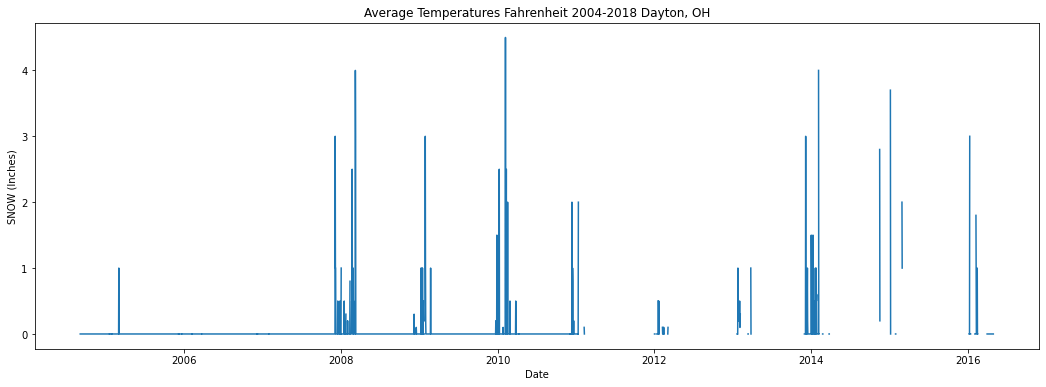

In [215]:
#Create a plot to see where these null values are

plt.figure(figsize=(18,6))
sns.lineplot(data=df_weather, x="Date", y="SNOW (Inches)", palette='viridis')
plt.title("Average Temperatures Fahrenheit 2004-2018 Dayton, OH")
plt.show()

It looks like there are null values in the summers..? For now I'll just put them as 0 as well

In [216]:
df_weather['SNOW (Inches)'].fillna(value=0, inplace = True)

In [217]:
df_weather.isnull().sum()

Date                            0
TAVG (Degrees Fahrenheit)       0
TMAX (Degrees Fahrenheit)       0
TMIN (Degrees Fahrenheit)       0
PRCP (Inches)                   0
SNOW (Inches)                   0
SNWD (Inches)                1780
dtype: int64

I'm not sure if SNWD will really matter here, so I'll jsut remove the column altogether

In [218]:
df_weather.drop('SNWD (Inches)', axis=1, inplace=True)

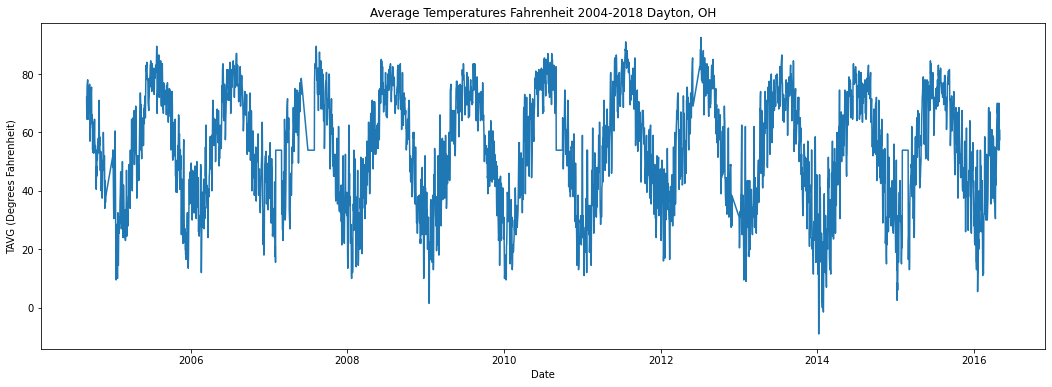

In [219]:
plt.figure(figsize=(18,6))
sns.lineplot(data=df_weather, x="Date", y="TAVG (Degrees Fahrenheit)", palette='viridis')
plt.title("Average Temperatures Fahrenheit 2004-2018 Dayton, OH")
plt.show()

### Merging the two data sets together

In [220]:
#I'm going to want the energy data into day form to match the weather data

df_energy['Date'] = pd.to_datetime(df_energy['Datetime']).dt.date

In [221]:
df_energy['Date'] = pd.to_datetime(df_energy['Date'])

In [222]:
df_energy = df_energy.set_index('Date')

In [223]:
df_energy = df_energy.resample('D').mean()

In [224]:
df_energy = df_energy.reset_index()

In [225]:
df=pd.merge(df_energy, df_weather, on="Date", how="inner")

In [226]:
df = df.set_index('Date')

In [227]:
df.head()

,DAYTON_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches)
Date,,,,,,,,,,,,,,
2004-10-01,1924.130435,12.0,4.0,4.0,10.0,2004.0,275.0,1.0,40.0,59.047637,74.0,44.095274,0.0,0.0
2004-10-02,1641.583333,11.5,5.0,4.0,10.0,2004.0,276.0,2.0,40.0,63.500000,78.0,49.000000,0.0,0.0
2004-10-03,1528.708333,11.5,6.0,4.0,10.0,2004.0,277.0,3.0,40.0,53.000000,67.0,39.000000,0.0,0.0
2004-10-04,1926.541667,11.5,0.0,4.0,10.0,2004.0,278.0,4.0,41.0,55.000000,70.0,40.000000,0.0,0.0
2004-10-05,1970.125000,11.5,1.0,4.0,10.0,2004.0,279.0,5.0,41.0,53.000000,69.0,37.000000,0.0,0.0


Success!!

### Establishing Benchmark Forecasts

In [228]:
#Naive forecast (take the last known value and assume the future will be the same)

size = int(len(df)*0.8)
df_naive, df_naive_test = df.iloc[:size], df.iloc[size:]
df_naive_test['Forecast'] = df_naive.iloc[-1]['DAYTON_MW']

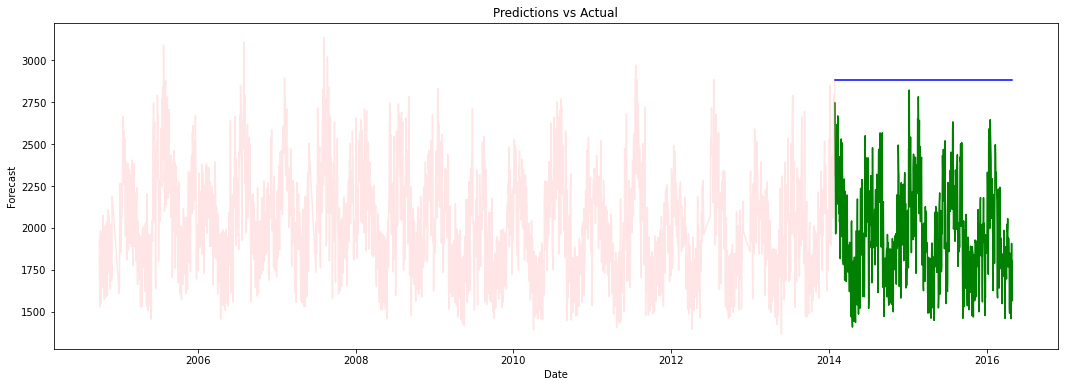

In [229]:
plt.figure(figsize=(18,6))
sns.lineplot(data=df_naive_test, x='Date', y='Forecast',color='blue')
sns.lineplot(data=df_naive_test, x='Date', y='DAYTON_MW',color='green')
sns.lineplot(data=df_naive, x='Date', y='DAYTON_MW',color='red', alpha=0.1)
plt.title("Predictions vs Actual")
plt.show()

In [230]:
#Mean forecast (take the mean of the known values and assume the future will be the same)

size = int(len(df)*0.8)
df_mean, df_mean_test = df.iloc[:size], df.iloc[size:]
df_mean_test['Forecast'] = df_mean['DAYTON_MW'].mean()

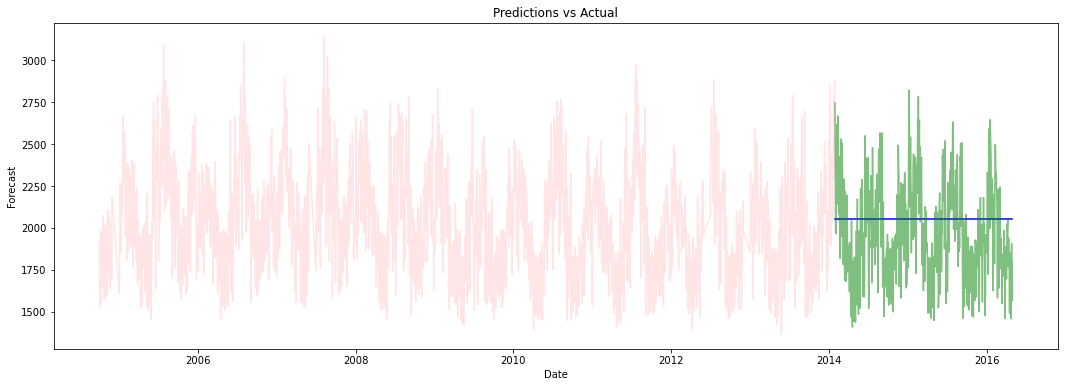

In [231]:
plt.figure(figsize=(18,6))
sns.lineplot(data=df_mean_test, x='Date', y='Forecast',color='blue')
sns.lineplot(data=df_mean_test, x='Date', y='DAYTON_MW',color='green', alpha=0.5)
sns.lineplot(data=df_mean, x='Date', y='DAYTON_MW',color='red', alpha=0.1)
plt.title("Predictions vs Actual")
plt.show()

### Linear Regression Model

In [232]:
#Checking stationarity with the Dickey Fuller Test

print ('Results of Dickey-Fuller Test:')
adf_test = sts.adfuller(df['DAYTON_MW'],autolag='AIC')
dfoutput = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in adf_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.223834e+00
p-value                        2.077797e-10
#Lags Used                     2.800000e+01
Number of Observations Used    4.078000e+03
Critical Value (1%)           -3.431955e+00
Critical Value (5%)           -2.862249e+00
Critical Value (10%)          -2.567147e+00
dtype: float64


The data is stationary! 

In [233]:
model = LinearRegression()

In [234]:
size = int(len(df)*0.8)
df_linear_temp, df_linear_temp_test = df.iloc[:size], df.iloc[size:]

x_train = df_linear_temp[['TAVG (Degrees Fahrenheit)']]
y_train = df_linear_temp['DAYTON_MW']

x_test = df_linear_temp_test[['TAVG (Degrees Fahrenheit)']]
y_test = df_linear_temp_test[['DAYTON_MW']]

In [235]:
model.fit(x_train, y_train)

LinearRegression()

In [236]:
predictions = model.predict(x_test)

In [237]:
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The R2 is:', r2)
print('The RSME is:', rmse)

The R2 is: -0.06584880793105086
The RSME is: 284.17595793240247


In [238]:
index_list = y_test.index
predictions = pd.DataFrame(predictions, index=index_list)

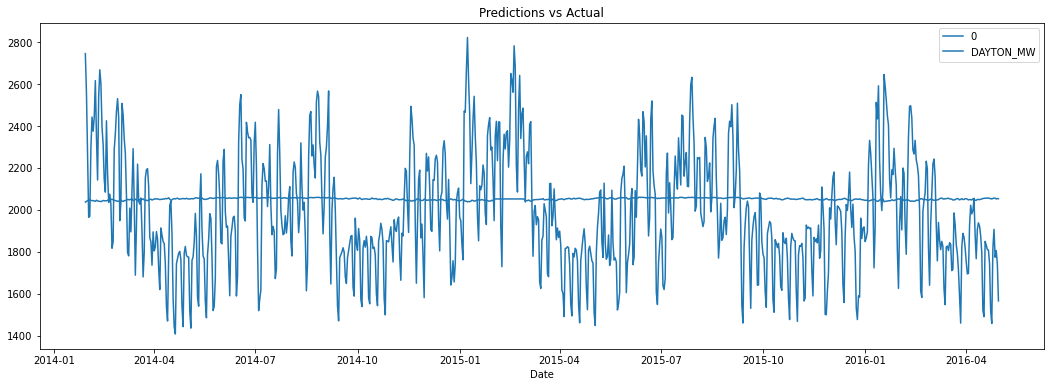

In [239]:
plt.figure(figsize=(18,6))
sns.lineplot(data=predictions, color='blue')
sns.lineplot(data=y_test, color='green')
plt.title("Predictions vs Actual")
plt.show()

Not a great predictor... time to add more variables to the mix

### Multivariable Regression

In [274]:
df_linear_temp_, df_linear_temp_test = df.iloc[:size], df.iloc[size:]

x_train = df_linear_temp[['TAVG (Degrees Fahrenheit)', 'dayofyear', 'month', 'dayofmonth']]
y_train = df_linear_temp['DAYTON_MW']

x_test = df_linear_temp_test[['TAVG (Degrees Fahrenheit)', 'dayofyear', 'month', 'dayofmonth']]
y_test = df_linear_temp_test[['DAYTON_MW']]

In [275]:
multi_model = LinearRegression()

In [276]:
multi_model.fit(x_train, y_train)

LinearRegression()

In [277]:
predictions = multi_model.predict(x_test)

In [278]:
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The R2 is:', r2)
print('The RSME is:', rmse)

The R2 is: 0.033436777788225625
The RSME is: 290.63733493116393


In [279]:
index_list = y_test.index
predictions = pd.DataFrame(predictions, index=index_list)

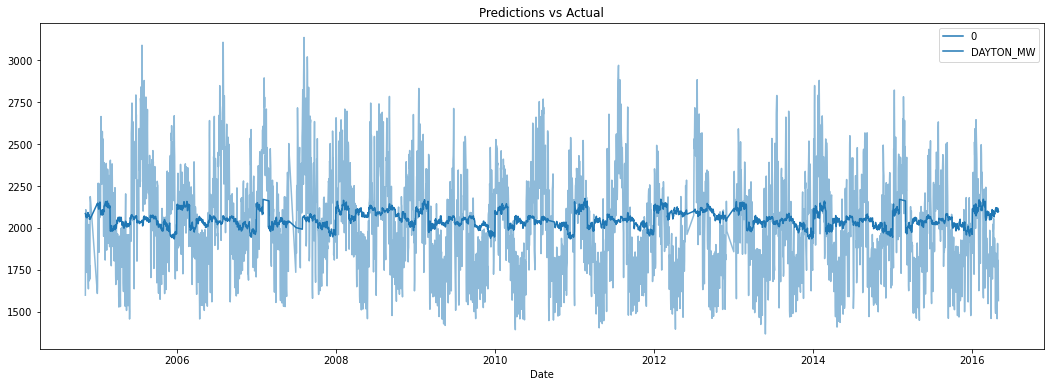

In [280]:
plt.figure(figsize=(18,6))
sns.lineplot(data=predictions, color='blue')
sns.lineplot(data=y_test, color='green', alpha=0.5)
plt.title("Predictions vs Actual")
plt.show()

It looks somewhat better! But I wonder if we can do better...

### Build an AutoARIMA Model with Quarterly Data

In [259]:
df_quarterly = df.resample('Q').mean()

In [260]:
#Split the test set and train set (80-20 split)

size = int(len(df_quarterly)*0.8)
df_quarterly, df_quarterly_test = df_quarterly.iloc[:size], df_quarterly.iloc[size:]
df_quarterly.drop(df_quarterly.columns[1:, ], axis = 1, inplace = True)
df_quarterly_test.drop(df_quarterly_test.columns[1:, ], axis = 1, inplace = True)

In [262]:
#Create a model

smodel = pm.auto_arima(df_quarterly.DAYTON_MW, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, m=4,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=388.871, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=386.237, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=387.164, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=384.761, Time=0.05 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=385.372, Time=0.05 sec
 ARIMA(2,1,0)(2,1,0)[4]             : AIC=386.127, Time=0.07 sec
 ARIMA(1,1,1)(2,1,0)[4]             : AIC=384.452, Time=0.09 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(2,1,1)[4]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(2,1,0)[4]             : AIC=383.155, Time=0.05 sec
 ARIMA(0,1

In [263]:
#Forecast

#index_list = df_quarterly_test['Date']
predictions, confint = smodel.predict(n_periods=10, return_conf_int = True)
predictions = pd.DataFrame(predictions)
df_quarterly_test['Forecast'] = predictions.to_numpy()
df_quarterly_test['lower'] = confint[:,0]
df_quarterly_test['upper'] = confint[:,1]

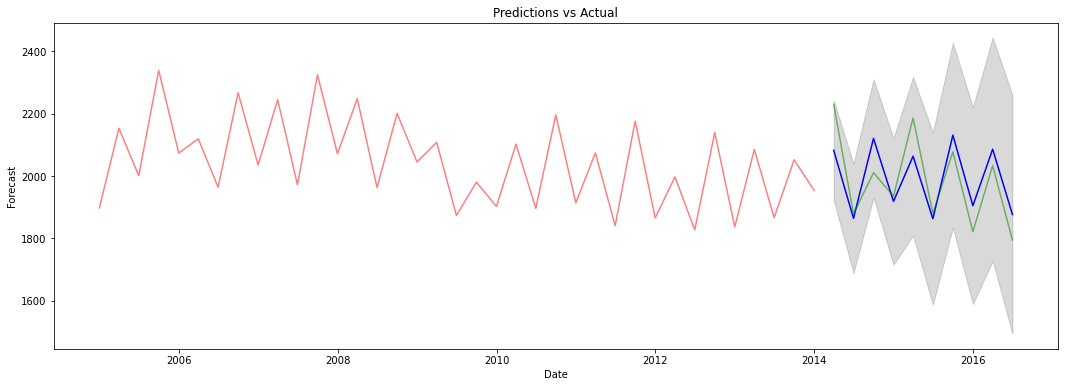

In [264]:
plt.figure(figsize=(18,6))
sns.lineplot(data=df_quarterly_test, x='Date', y='Forecast', color='blue')
sns.lineplot(data=df_quarterly_test, x='Date', y='DAYTON_MW', color='green', alpha=0.5)
sns.lineplot(data=df_quarterly, x='Date', y='DAYTON_MW',color='red', alpha=0.5)
plt.title("Predictions vs Actual")
plt.fill_between(df_quarterly_test.index, df_quarterly_test['lower'], df_quarterly_test['upper'], color='k', alpha=.15)
plt.show()

In [265]:
r2 = r2_score(df_quarterly_test['DAYTON_MW'], df_quarterly_test['Forecast'])
rmse = mean_squared_error(df_quarterly_test['DAYTON_MW'], df_quarterly_test['Forecast'], squared=False)

print('The R2 is:', r2)
print('The RSME is:', rmse)

The R2 is: 0.6550696263588696
The RSME is: 82.96314938550378


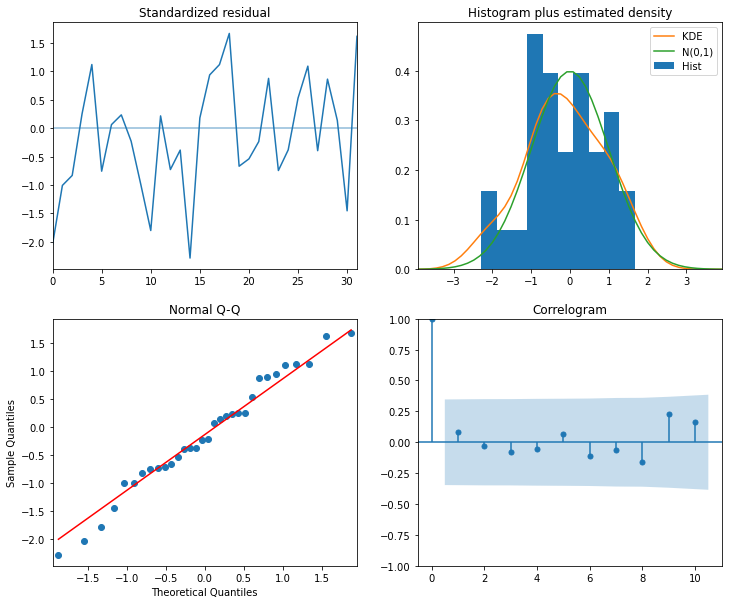

In [266]:
smodel.plot_diagnostics(figsize=(12,10))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.
 - it looks like there is a pattern at lag 7 that are not being explained by the model, I wonder what that is
 - "The autocorrelation plot shows a significant spike at lag 7, and a significant Ljung-Box test at the 5% level. However, the autocorrelation is not particularly large, and at lag 7 it is unlikely to have any noticeable impact on the forecasts or the prediction intervals." https://otexts.com/fpp3/regression-evaluation.html

Overall, it seems to be a good fit. 

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

### Trying a Hybrid Model with XGBoost

In [281]:
y_resid = df_quarterly_test['DAYTON_MW'] - df_quarterly_test['Forecast']

In [285]:
xgb = XGBRegressor()

In [293]:
x_train = df_quarterly_test.index

In [294]:
x_train = pd.DataFrame(x_train)

In [298]:
xgb.fit(x_train, y_resid)

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.Date

TODO: 

Should do a daily average instead of a monthly production because some months have more days than others

Should establish benchmarks (seasonal)
